## Training Section

### Preprocess   

* tfs --- TF with condition values as row
* genes -- genes to fit data

In [1]:
import numpy as np
import pandas as pd

In [4]:
gold_standard_file_path = 'dataset/gold/YEASTRACT_Count3.KO.txt'
expression_data_file_path = 'dataset/expression/KO.txt'


In [5]:
gold_standard = pd.read_csv (gold_standard_file_path,sep = '\t')
gold_standard_tfs = list(set(gold_standard.iloc[:,0]))
gold_standard_genes = list(set(gold_standard.iloc[:,1]))

In [6]:
dataset = pd.read_csv(expression_data_file_path, sep = '\t').set_index('Gene')

In [7]:
tfs = dataset.loc[gold_standard_tfs]
genes = dataset.loc[gold_standard_genes]

### LASSO Regression

In [8]:
from sklearn import model_selection
from sklearn.linear_model import Lasso, LassoCV

In [9]:
def lasso_regression(gene, tfs):
    # prepare data
    x = tfs.values.transpose()
    y = gene.values
    x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.1)
    
    # lasso train
    lasso_reg = LassoCV(alphas = [0.01, 0.1, 1, 10, 100], cv=5)
    lasso_reg.fit(x_train, y_train)

    #filter out zero coef
    predictions = tfs[lasso_reg.coef_ != 0]
    coef = lasso_reg.coef_[lasso_reg.coef_ != 0]
    return predictions.index,coef

In [10]:
lasso_infer = open("dataset/inferred/LASSO_gold_tf.txt","w") 
for i in range(len(genes)): 
    target_gene = genes.index[i]
    predictions,coef = lasso_regression(genes.iloc[i],tfs)
    for j  in range(len(predictions)):
        prediction = str(predictions[j])
        score = str(abs(coef[j]))
        lasso_infer.write( prediction  + ' ' + target_gene + ' '+ score + '\n')
lasso_infer.close()

## Evaluation Section
### assuming a 2 class (say 0, 1) classification problem 
### to build a roc curve, you just need a model which outputs a score, that is a function of the explanatory
### variables which allows to rank the individuals from the more likely to be in one class (say 0) to the less likely
### assuming the highest the score, the more likely to be in class 0
### given such score distribution, for a threshold within the range of the score, you classify individuals above this threshold as 0, the others as 1 and compute the TPR and FPR : this gives you one point of the ROC curve for the model (or rather for the score function associated to this model)
### varying the threshold across the score range, you get a more and more accurate approximation of the ROC curve
### you can do that for different models (models + scoring functions)
### you do not have to worry that you are using different thresholds for different models : thresholds are just tools to get the (FPR, TPR) curve``

In [2]:
import numpy as np
import pandas as pd

In [3]:
def evaluation(gold_standard_filepath,inferred_filepath):
    gold_standard = pd.read_csv (gold_standard_filepath,sep = '\t')
    gold_standard_tfs = list(set(gold_standard.iloc[:,0]))
    gold_standard_genes = list(set(gold_standard.iloc[:,1]))

    scores,labels = [],[]

    inferred_result = pd.read_csv(inferred_filepath,sep='\s+')
    inferred_result_dict = {}
    for index,rows in inferred_result.iterrows():
        inferred_result_dict[rows[0]+rows[1]] = rows[2]

    gold_standard_set = set()
    for index,rows in gold_standard.iterrows():
        gold_standard_set.add(rows[0]+rows[1])

    for tf in gold_standard_tfs:
        for gene in gold_standard_genes:
            if tf+gene in inferred_result_dict:
                scores.append(inferred_result_dict[tf+gene])
            else:
                scores.append(0)
            if tf+gene in gold_standard_set:
                labels.append(1)
            else:
                labels.append(0)

    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
    auc = metrics.roc_auc_score(labels, scores)
    aupr = metrics.average_precision_score(labels, scores)

    return labels,scores,fpr,tpr,thresholds,auc,aupr

    

In [33]:
gold_standard_filepaths = ['dataset\gold\MacIsaac2.KO.txt','dataset\gold\YEASTRACT_Count3.KO.txt','dataset\gold\YEASTRACT_Type2.KO.txt']
inferred_filepaths = ['dataset\inferred\LASSO_gold_tf.txt','dataset\inferred\Inferelator.KO.txt','dataset\inferred\GENIE3.KO.txt','dataset\inferred\MERLIN.KO.txt','dataset\inferred\LARSEN.KO.txt','dataset\inferred\MERLIN_motif.KO.txt','dataset\inferred\PGG.KO.txt','dataset\inferred\TIGRESS.KO.txt']

In [34]:
import pickle
for gold_standard_filepath in gold_standard_filepaths:
    for inferred_filepath in inferred_filepaths:
        file_path = gold_standard_filepath[13:gold_standard_filepath.index('.txt')] + '_' +inferred_filepath[17:inferred_filepath.index('.')]+'.pickle'
        print(file_path)
        try:
            pickle.load(open(file_path, "rb"))
        except (OSError, IOError) as e:
            labels,scores,fpr,tpr,thresholds,auc,aupr = evaluation(gold_standard_filepath,inferred_filepath)
            data = (labels,scores,fpr,tpr,thresholds,auc,aupr)
            pickle.dump(data, open(file_path, "wb"))

MacIsaac2.KO_LASSO_gold_tf.pickle
MacIsaac2.KO_Inferelator.pickle
MacIsaac2.KO_GENIE3.pickle
MacIsaac2.KO_MERLIN.pickle
MacIsaac2.KO_LARSEN.pickle
MacIsaac2.KO_MERLIN_motif.pickle
MacIsaac2.KO_PGG.pickle
MacIsaac2.KO_TIGRESS.pickle
YEASTRACT_Count3.KO_LASSO_gold_tf.pickle
YEASTRACT_Count3.KO_Inferelator.pickle
YEASTRACT_Count3.KO_GENIE3.pickle
YEASTRACT_Count3.KO_MERLIN.pickle
YEASTRACT_Count3.KO_LARSEN.pickle
YEASTRACT_Count3.KO_MERLIN_motif.pickle
YEASTRACT_Count3.KO_PGG.pickle
YEASTRACT_Count3.KO_TIGRESS.pickle
YEASTRACT_Type2.KO_LASSO_gold_tf.pickle
YEASTRACT_Type2.KO_Inferelator.pickle
YEASTRACT_Type2.KO_GENIE3.pickle
YEASTRACT_Type2.KO_MERLIN.pickle
YEASTRACT_Type2.KO_LARSEN.pickle
YEASTRACT_Type2.KO_MERLIN_motif.pickle
YEASTRACT_Type2.KO_PGG.pickle
YEASTRACT_Type2.KO_TIGRESS.pickle


In [35]:
import pickle
for gold_standard_filepath in gold_standard_filepaths:
    for inferred_filepath in inferred_filepaths:
        file_path = gold_standard_filepath[13:gold_standard_filepath.index('.txt')] + '_' +inferred_filepath[17:inferred_filepath.index('.')]+'.pickle'
        print(file_path)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            print('auc score: ',data[5], 'aupr score: ',data[6])

MacIsaac2.KO_LASSO_gold_tf.pickle
auc score:  0.5331315833032015 aupr score:  0.022168395705357676
MacIsaac2.KO_Inferelator.pickle
auc score:  0.6508681287687835 aupr score:  0.037915898935063634
MacIsaac2.KO_GENIE3.pickle
auc score:  0.5444423698913226 aupr score:  0.02099463563255754
MacIsaac2.KO_MERLIN.pickle
auc score:  0.5416161114125341 aupr score:  0.02441533638183685
MacIsaac2.KO_LARSEN.pickle
auc score:  0.521606326920628 aupr score:  0.02328284152468421
MacIsaac2.KO_MERLIN_motif.pickle
auc score:  0.6513096208967846 aupr score:  0.043913606771490386
MacIsaac2.KO_PGG.pickle
auc score:  0.5409608089963013 aupr score:  0.024030175486527486
MacIsaac2.KO_TIGRESS.pickle
auc score:  0.5301934267234225 aupr score: 0.022089286982018622
YEASTRACT_Count3.KO_LASSO_gold_tf.pickle
auc score:  0.5239876120637612 aupr score:  0.02253018890593326
YEASTRACT_Count3.KO_Inferelator.pickle
auc score:  0.640504714475699 aupr score:  0.03480186142870919
YEASTRACT_Count3.KO_GENIE3.pickle
auc score:  

In [67]:
import matplotlib.pyplot as plt

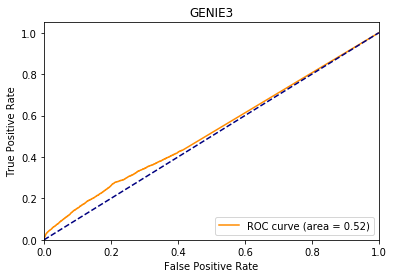

In [32]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
        label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GENIE3')
plt.legend(loc="lower right")
plt.show()